***Parameter Definitions***

In [10]:
nx, ny, nz              = 32, 32, 8                    # Spatial Dimension
n_alphas                = 4
n_thetas                = 4
m                       = n_alphas * n_thetas          # Number of Patterns
dd_factor               = 2                            # Detector Downsampling Factor

Load object

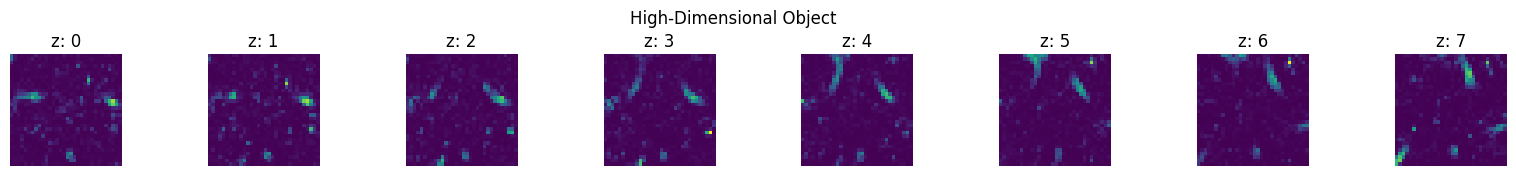

In [11]:
from libs.forward_lib.read_data import ReadData

RD = ReadData(nx, ny, nz, up_factor=0.25)
RD.load_object("blood_cell")
RD.visualize_data(is_orginal=True, n_planes=8)

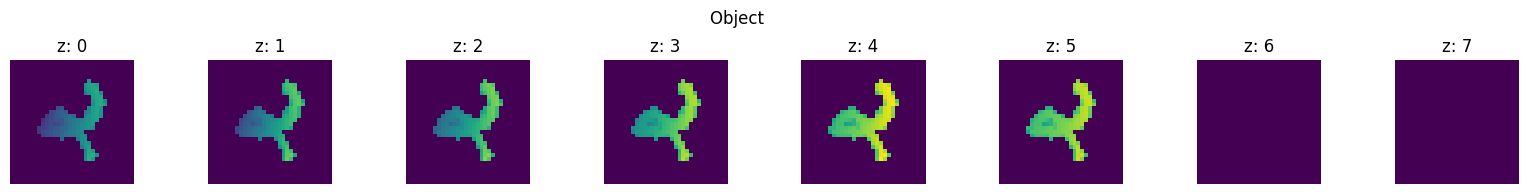

In [4]:
from libs.forward_lib.simulate_data import MnistSimulator

MS = MnistSimulator(nx, ny, nz, up_factor=(6/28,1,1))
MS.update_data()
MS.visualize_object(vis_planes=True)

Linearized Model

Linearized Model Specifications
----------------------------------------------
NA 				: 0.8
Space Dimension 		: 32.000um × 32.000um × 8.000um
Voxel Size 			: 1.0um × 1.0um × 1.0um
Original Shape 			: 32 × 32 × 8
D2NN Patterns 			: 16
# of Plane			: 1
Detector Pool size 		: 2×2
Computational Device 		: cpu




Pattern: 16/16	 Nz: 100%|██████████| 8/8 [00:02<00:00,  2.67it/s]


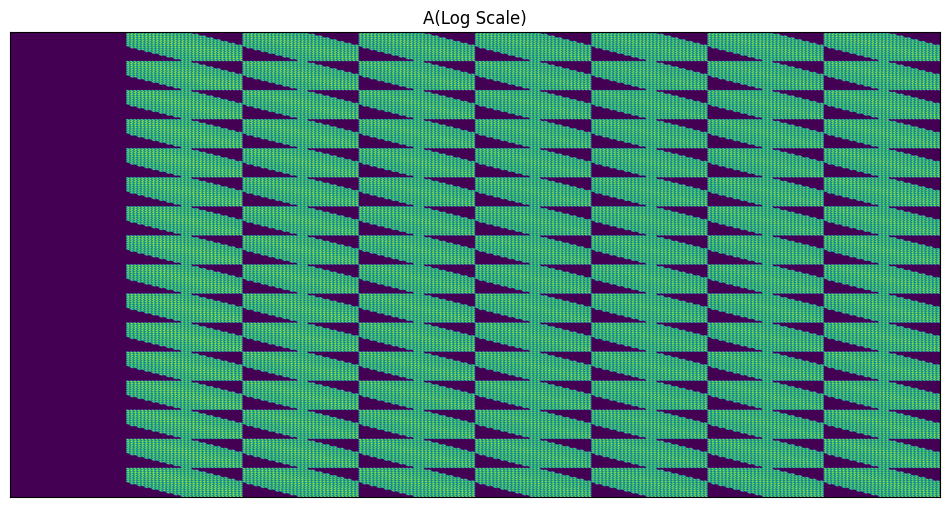

In [12]:
from libs.forward_lib.linearized_process_D2NN import LinearizedModel

LM = LinearizedModel(nx, ny, nz, n_alphas, n_thetas, dd_factor, n_planes=1)
LM.init_models()
print(LM)

LM.find_transformation()
# LM.visualize_A()

FM = LM.A.cpu().numpy()

In [15]:
import numpy as np

X = RD.X.cpu().numpy().reshape(nx*ny*nz, 1)
y_clean = FM@X

def add_gaussian_noise(signal, snr_dB):
    signal_power = np.mean(signal**2)
    snr = 10**(snr_dB/10.0)
    noise_power = signal_power/snr
    noise = np.random.randn(*signal.shape) * np.sqrt(noise_power)
    noisy_signal = signal + noise
    return noisy_signal

desired_snr_dB = 20.0
y_noisy = add_gaussian_noise(y_clean, desired_snr_dB).reshape(m*(nx//dd_factor)*(ny//dd_factor), 1)

Run twist


Initial objective = 6148.0298014609925, nonzeros = 0
Incrementing S = 2
Incrementing S = 4
Incrementing S = 8
Incrementing S = 16
Incrementing S = 32
Incrementing S = 64
Incrementing S = 128
Incrementing S = 256
Incrementing S = 512
Incrementing S = 1024
Iteration = 2, objective = 478.25336565279036, nz = 8192, criterion = 92.22103045858462
Iteration = 3, objective = 226.66400485584433, nz = 8192, criterion = 52.6058735527224
Iteration = 4, objective = 151.21227350532183, nz = 8192, criterion = 33.287919446455085
Iteration = 5, objective = 110.13378133515971, nz = 8192, criterion = 27.166109746188287
Iteration = 6, objective = 100.82562110499882, nz = 8192, criterion = 8.451684957437584
Iteration = 7, objective = 97.08441979695301, nz = 8192, criterion = 3.7105660912812546
Iteration = 8, objective = 93.72696832511487, nz = 8192, criterion = 3.4582804108631238
Iteration = 9, objective = 89.4943702952477, nz = 8192, criterion = 4.515880653672018
Iteration = 10, objective = 83.3904371801

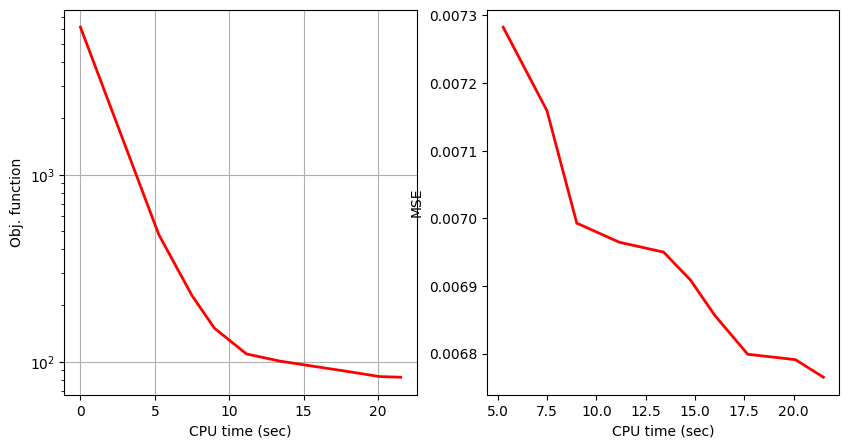

TwIST CPU time: 21.515625
MSE Loss: 6.7651e-03


f:\miniconda3\envs\FYP2\lib\site-packages\skimage\metrics\simple_metrics.py:163: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10((data_range ** 2) / err)


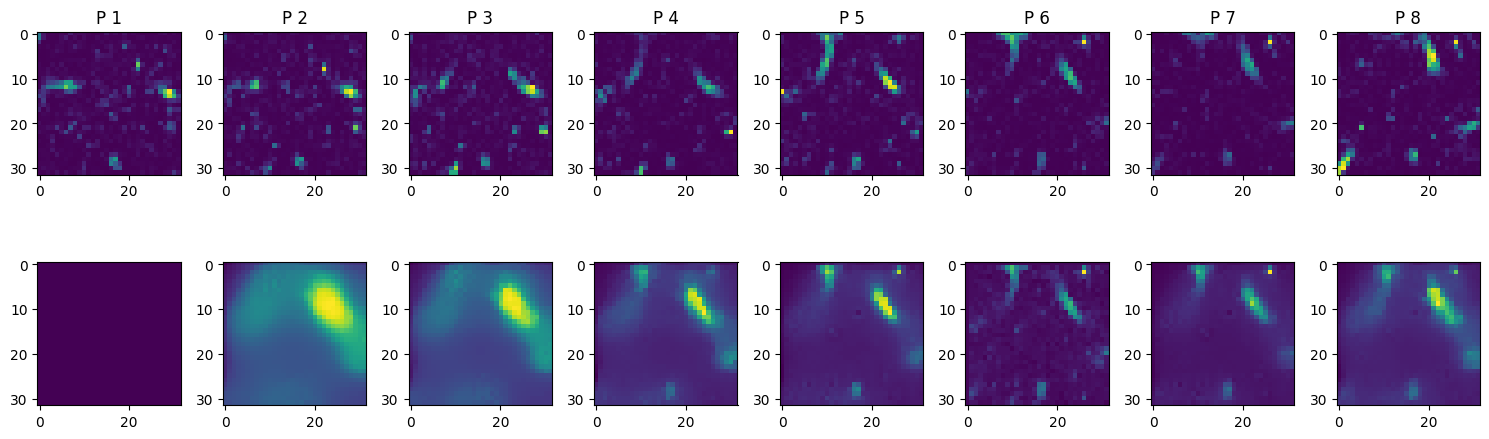

plane 1 | SSIM = 0.0000 | PSNR = -inf dB
plane 2 | SSIM = 0.0098 | PSNR = -6.5294 dB
plane 3 | SSIM = 0.0264 | PSNR = -3.8415 dB
plane 4 | SSIM = 0.0897 | PSNR = 2.1473 dB
plane 5 | SSIM = 0.0728 | PSNR = 0.5072 dB
plane 6 | SSIM = 0.7683 | PSNR = 25.8154 dB
plane 7 | SSIM = 0.1008 | PSNR = 3.1069 dB
plane 8 | SSIM = 0.0509 | PSNR = 0.3949 dB


In [16]:
import libs.reconstruction_lib.TWIST as TWIST
import libs.reconstruction_lib.twist_utils as utils

y = y_noisy

tau = 1/10 # Regularization parameter
Psi = 'TV' # denoising function ('TV', 'SOFT', 'SOFT_DWT')
Phi = 'TV' # regularization function ('TV', 'L1', 'L1_DWT')
lam1 = 1e-4 # twist parameter
stop_criterion = 1 # 0:non-zero components, 1:change in obj func, 2:estimate, 3:value of obj func 
tolA = 1e-2 # Stopping threshold
init = 0 # 0:zero, 1:random, 2:Aty, 3:init_x given by user
init_x = None # initial estimate

x_twist, dummy, obj_twist, times_twist, dummy, mse_twist, dummy = TWIST.TwIST(y, FM, tau, nx, ny, nz,
                                                                                Psi=Psi, Phi=Phi,
                                                                                lam1=1e-4, alpha=0, beta=0,
                                                                                stop_criterion=stop_criterion, tolA=tolA,
                                                                                init=init, init_x=init_x,
                                                                                enforceMonotone=1,
                                                                                true_x=X, compute_mse=1,
                                                                                verbose=1)

utils.plot_obj_mse(obj_twist, times_twist, mse_twist, figsize=(10,5))

ssim_values, psnr_values = utils.comparison2(X, x_twist, nx, ny, nz, figsize=(15, 5), planes_to_plot=range(nz))